<a href="https://colab.research.google.com/github/amalvarezme/AprendizajeMaquina/blob/main/5_DeepLearning/1_Introduction_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción a las redes neuronales profundas

- Se presentan los principios básicos de funcionamiento de las redes neuronales a partir del perceptrón simple hasta perceptrones multicapa.

- Se implementan arquitecturas secuenciales utilizando la librería [TensorFlow](https://www.tensorflow.org/overview?hl=es-419) y la [API Keras](https://keras.io/).

## Perceptrón

- El perceptrón presenta un modelo lineal de la forma:

$$\hat{y} = {\rm{sign}}(\mathbf{w}^\top \mathbf{x}) $$

- Para optimizarlo, se plantea un algoritmo de gradiente descendiente estocástico:

$$\mathbf{w}^* = \arg\max_{\mathbf{w}} - \sum_{\mathbf{x}_n\in \mathbf{X}}\langle \mathbf{w}^\top \mathbf{x}_n ,y_n\rangle$$

$$\mathbf{w}_i =\mathbf{w}_{i-1}-\eta_i \mathbf{x}_ny_n$$

donde $\mathbf{x}_n,\mathbf{w}\in\mathbb{R}^P$ corresponde a la $n$-ésima muestra y al vector de pesos; $y_n\in\{-1,+1\}$ son las etiquetas objetivo, y $\eta_i\in \mathbb{R}^+$ es el hiperparámetro tasa de aprendizaje (learning rate).

**Scikit-Learn** proporciona una clase *Perceptron* que implementa una única red.

In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X    = iris.data[:, (2, 3)]  # petal length, petal width
y    = (iris.target == 0)/1.0

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])
print(X.shape)
print(y.shape)

(150, 2)
(150,)


In [2]:
y_pred

array([1.])

- Se presenta la frontera de decisión mediante la curva $f(\mathbf{x})=0$.

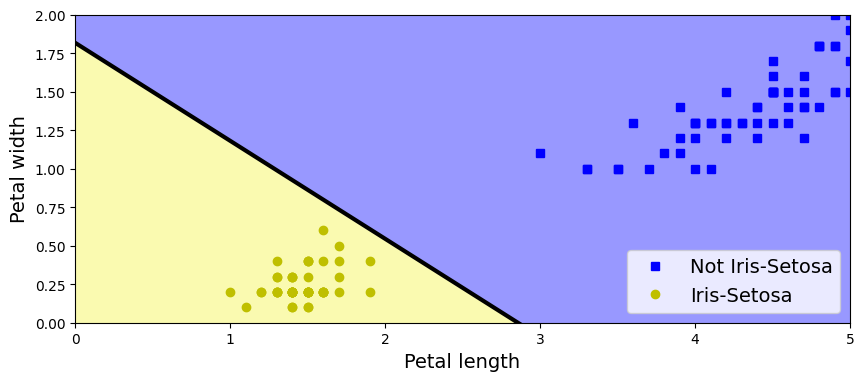

In [3]:
# Graficar fronteras de decisión
#---------------------------
import matplotlib.pyplot as plt

a      = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b      = -per_clf.intercept_ / per_clf.coef_[0][1]
axes   = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new     = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz        = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

#save_fig("perceptron_iris_plot")
plt.show()

El **algoritmo de aprendizaje** de Perceptron se parece mucho al **SGD**. De hecho, la clase de *Perceptron* de Scikit-Learn es equivalente a usar *SGDClassifier* con los siguientes hiperparámetros:
- *loss*          = "perceptron",
- *learning_rate* = "constant",
- *eta0*          = 1 (la tasa de aprendizaje) y
- *penalty*       = "None" (sin regularización).

- Tengamos en cuenta que, al **contrario de los clasificadores de regresión logística**, los perceptrones **no generan una probabilidad de clase; más bien, solo hacen predicciones basadas en un umbral de decisión - distancia a la frontera**.

- Esta es una de las buenas razones para preferir la Regresión logística sobre los Perceptrones.

## Funciones de activación

- En general, un modelo de redes neuronales profundas, se pueden ver como una función compuesta, mediante productos lineales en cascada con funciones de activación no lineal.

- La función signo y la función escalón, presentan discontinuidades de primer orden, lo que inestabiliza sus gradientes.

- Por ende, se prefiere trabajar con funciones sigmoide, relu, y tanh:

  $${\rm{sigmoid}}(x)=\frac{1}{1+e^{-x}}$$

  $${\rm{relu}}(x)=\max(0,x)$$

  $${\rm{tanh}}(x)=\frac{e^x-e^{-x}}{e^x+e^{-x}}$$


In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):#se presentan las derivadas numéricas
    return (f(z + eps) - f(z - eps))/(2 * eps)

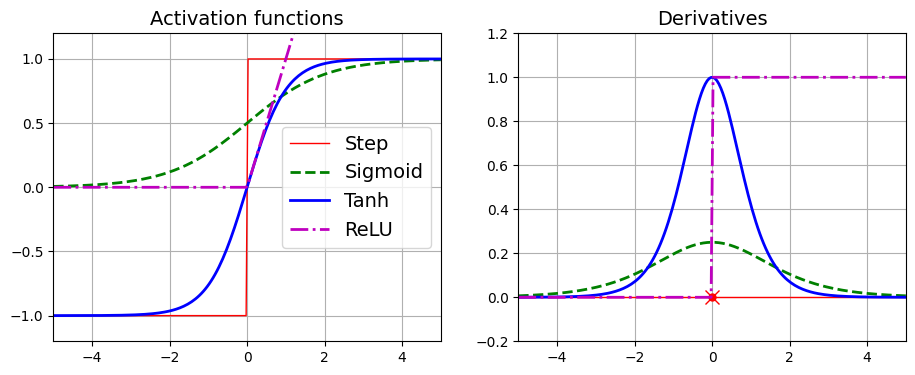

In [5]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

#save_fig("activation_functions_plot")
plt.show()

# Del perceptrón simple al perceptrón multicapa y las redes profundas.

- Utilizando el mismo  principio del perceptrón, se pueden apilar varias capas (perceptrón multicapa) para mejorar la representación de los datos:

![mlp](https://github.com/amalvarezme/AnaliticaDatos/blob/master/5_Aprendizaje_Profundo/mlp.png?raw=1)

- En este sentido, una buena combianción de capas y neuronas (depurar el espacio de representación) junto con activación apropiadas (codificar patrones no lineales), permite encontrar estructuras relevantes de datos bajo un esquema de optimización por gradiente descendiente (escalable y paralelizable).

- Ver [plataforma playground TensorFlow](https://playground.tensorflow.org/) para manipular distintas configuración del perceptrón multicapa.

- En general, la capacidad de representación de los modelos profundos (deep learning por sus siglas en inglés), al apilar distintas capas, neuronas, y activación, se soporta bajo cuatro aspectos principales:

  -- Buena disponibilidad de datos de proceso.

  -- Optimización mediante gradiente descendiente y el algoritmo backpropagation.

  -- Paralelización de los procesos de optimización mediante, [CPU](https://en.wikipedia.org/wiki/Central_processing_unit), [GPU](https://en.wikipedia.org/wiki/Graphics_processing_unit) y [TPU](https://en.wikipedia.org/wiki/Tensor_Processing_Unit).

  -- **NO** se requiere calcular derivadas simbólicas, en cambio, se estiman mediante [derivación automática](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/5_DeepLearning/2_Autodiff.pdf)

## Construyendo un clasificador de imágenes

- Ahora extenderemos el perceptrón simple, a arquitecturas más complejas que puedan ser paralelizadas mediante GPU utilizando TensorFlow y Keras, y que además permitan el cálculo automático de las derivadas.

In [6]:
import tensorflow as tf
from tensorflow import keras

In [7]:
tf.__version__

'2.18.0'

- Comencemos cargando el conjunto de datos **Fashion MNIST**.

- Keras tiene una serie de funciones para cargar conjuntos de datos populares en *keras.datasets*.

- El conjunto de datos ya está dividido entre un **conjunto de entrenamiento** y un **conjunto de prueba**, pero puede ser útil dividir aún más el conjunto de entrenamiento para tener un **conjunto de validación**:

In [8]:
fashion_mnist = keras.datasets.fashion_mnist #cargar fashion mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


El **conjunto de entrenamiento** contiene 60,000 imágenes en escala de grises, cada una de $28\times 28$ píxeles:

In [9]:
X_train_full.shape

(60000, 28, 28)

Cada intensidad de píxel se representa como un byte (0 a 255):

In [10]:
X_train_full.dtype

dtype('uint8')

- Dividamos el **conjunto de entrenamiento** completo en un **conjunto de validación** y un conjunto de entrenamiento (*más pequeño*) mediante la estrategia de validación HoldOut.

- También **escalamos las intensidades de píxeles hasta el rango 0-1** y las convertimos en flotantes, dividiéndolas por 255.

In [11]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Se puede graficar una imagen usando la función *imshow()* de Matplotlib, con un mapa de color 'binario':

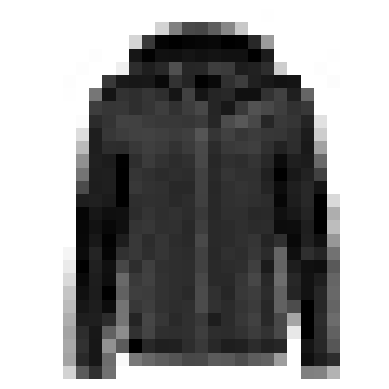

In [12]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

Las etiquetas son los ID de clase (representados como *uint8*), de 0 a 9:

In [13]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Aquí están los nombres de clase correspondientes:

In [14]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Entonces, la primera imagen en el conjunto de entrenamiento es un abrigo:

In [15]:
class_names[y_train[0]]

'Coat'

El **conjunto de validación** contiene 5,000 imágenes, y el **conjunto de prueba** contiene 10,000 imágenes:

In [16]:
X_valid.shape

(5000, 28, 28)

In [17]:
X_test.shape

(10000, 28, 28)

Echemos un vistazo a una muestra de las imágenes en el conjunto de datos:

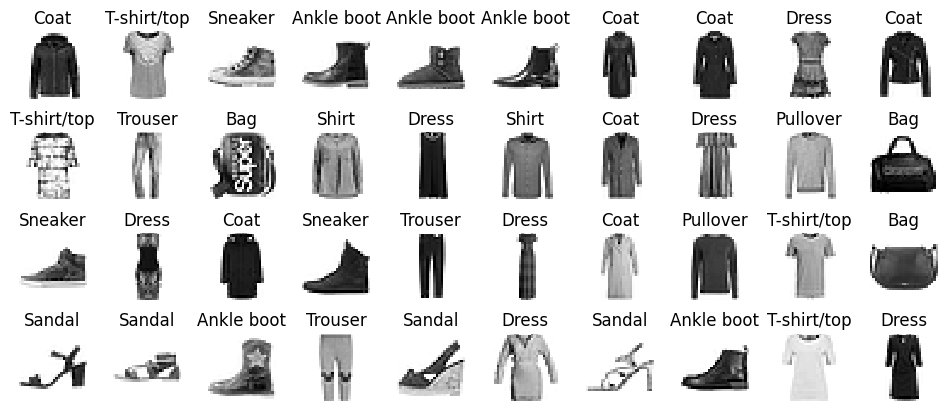

In [18]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

## Crear el modelo usando la API secuencial

- ¡Ahora construyamos la red neuronal!.

- Se implementará un perceptrón multicapa (MLP por sus siglas en inglés), con dos capas ocultas:

In [19]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))#capa de aplanado->convierte imagen en vector
model.add(keras.layers.Dense(300, activation="relu"))#capa densa con 300 neuronas y función de activación relu
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))#la capa de salida utiliza una softmax

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Veamos este código línea por línea:
- La primera línea crea un modelo secuencial. Este es el tipo más simple de modelo Keras, para redes neuronales que están compuestas de una sola pila de capas, conectadas secuencialmente. Esto se llama la **API secuencial**.

- Luego, construimos la primera capa y la agregamos al modelo. Es una capa Flatten cuyo papel es simplemente convertir cada imagen de entrada en una matriz 1D. Alternativamente, puede agregar un keras.layers.InputLayer como la primera capa, estableciendo $shape = [28,28]$.

- A continuación, agregamos una capa oculta densa con 300 neuronas. Utilizará la función de activación ReLU. Cada capa densa gestiona su propia matriz de peso, que contiene todos los pesos de conexión entre las neuronas y sus entradas. También gestiona un vector de términos de sesgo (uno por neurona).

- A continuación, agregamos una segunda capa oculta densa con 100 neuronas, que también utiliza la función de activación ReLU.

- Finalmente, agregamos una capa de salida densa con 10 neuronas (una por clase), usando la función de activación softmax (porque las clases son exclusivas).

**Nota**: La activación softmax se puede entender como una generalización de la sigmoid para problemas multiclase, para estimar la probabilidad de membresia $\hat{p}(A_c|\mathbf{x})$:

$${\rm{softmax}}(\mathbf{z})= \left\{\sigma({z}_c)=\frac{e^{z_c}}{\sum\nolimits_{k=1}^C e^{z_k}}\right\}$$
donde $\sigma(z_c)\in[0,1]$ y $\sum_{c=1}^C \sigma(z_c)=1$.



In [20]:
keras.backend.clear_session() #se sugiere limpiar la sesión para liberar los grafos computacionales
np.random.seed(42) #se fija semilla de numpy y tf
tf.random.set_seed(42)

En lugar de agregar las capas una por una como acabamos de hacer, se puede **pasar una lista de capas al crear el modelo secuencial**:

In [21]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

- Las capas quedan guardadas en un grafo computacional para facilitar el cálculo de derivadas automáticas y la paralelización en GPU/TPU.

In [22]:
model.layers

[<Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dense name=dense_1, built=True>,
 <Dense name=dense_2, built=True>]

# Modelo y optimización en aprendizaje profundo

- En general, un modelo de aprendizaje profundo se puede escribir como una función compuesta de la forma:

$$\hat{y}=(f_L\circ f_{L-1}\circ\cdots\circ f_1)(\mathbf{x})$$

donde $L$ representa el número de capas y:

$$\mathbf{z}_l=f_l(\mathbf{z}_{l-1})=\varphi(\mathbf{z}_{l-1}\mathbf{W}_{l}+\mathbf{b}_l)$$
donde $\varphi(\cdot)$ es una función de activación, $\mathbf{W}_{l}\in\mathbb{R}^{Q_{l-1}\times Q_{l}},$ $\mathbf{b}_{l}\in\mathbb{R}^{Q_{l}},$ $\mathbf{z}_l\in\mathbb{R}^{Q_l}$ y $Q_l$ representa la cantidad de neuronas en la $l$-ésima capa.

- A partir del modelo planteado, se puede generar el siguiente problema de optimización:

$$\theta^* = \arg\min_{\theta} \mathbb{E}\{\mathscr{L}(y_n,\hat{y}_n|\theta): \forall n \in \{1,2,\dots,N\}\}$$
donde $\theta = \{\mathbf{W}_l,\mathbf{b}_l\}^L_{l=1}$ contiene el set de parámetros de la red y $\mathscr{L}(\cdot,\cdot|\theta)$ es una función de costo dada.



- Se puede resumir la arquitectura y presentar mediante diagrama de bloques:

In [23]:
model.summary() #resumen con numero de parámetros y entradas-salidas por capa

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 266,610 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

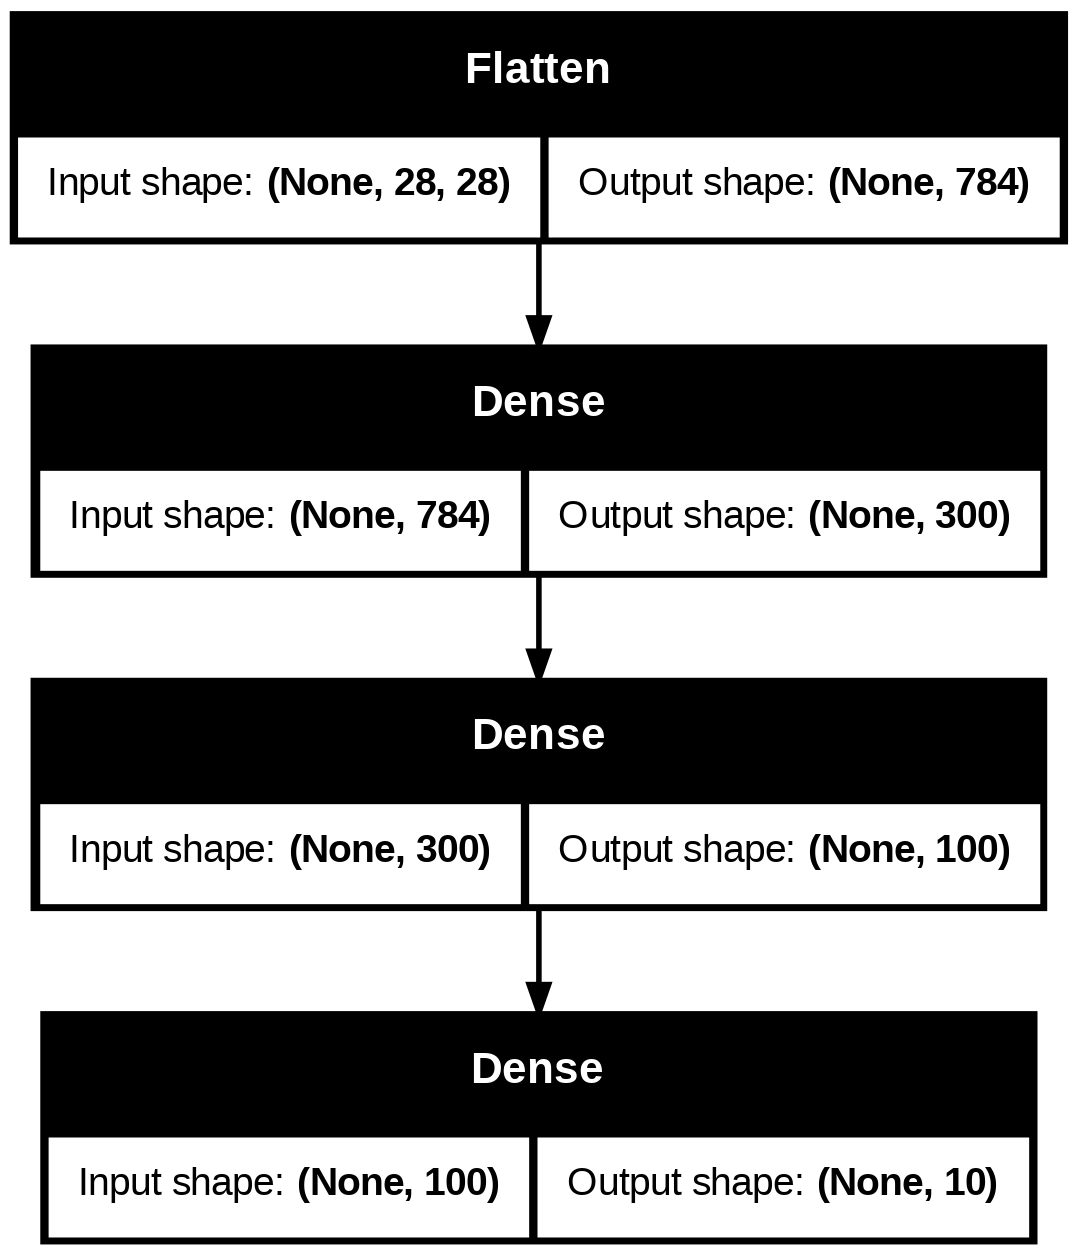

In [24]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

In [25]:
hidden1 = model.layers[1] #acceder a la primera capa densa
hidden1.name

'dense'

In [26]:
model.get_layer(hidden1.name) is hidden1 #también podemos acceder a la capa por su nombre

True

## Accediendo a los pesos y bias entrenados

- Con el fin de favorecer el entrenamiento, los pesos de cada capa se inicializan de forma aleatoria. Los bias se inicializan en ceros.

In [27]:
weights, biases = hidden1.get_weights()

In [28]:
weights

array([[ 0.07148972,  0.06370746, -0.00804546, ...,  0.00206437,
         0.04723443, -0.06352009],
       [-0.05136091, -0.03366552,  0.05941091, ...,  0.00988013,
        -0.02385222, -0.06779759],
       [-0.05099844, -0.01603803,  0.06295516, ..., -0.02932615,
        -0.00848992,  0.06526305],
       ...,
       [ 0.00142055,  0.00613451, -0.00519501, ...,  0.03790712,
         0.06495714, -0.06432948],
       [ 0.0388001 , -0.01589193, -0.06164898, ...,  0.07156231,
         0.00913719,  0.0247773 ],
       [ 0.03866072, -0.02473776, -0.05390076, ...,  0.0582204 ,
         0.00695048,  0.01371081]], dtype=float32)

In [29]:
weights.shape

(784, 300)

In [30]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [31]:
biases.shape

(300,)

### Compilando el modelo

- Después de crear un modelo, debe llamar a su método *compile()* para especificar la función de pérdida y el optimizador a utilizar.

- Opcionalmente, también puede especificar una lista de métricas adicionales para calcular durante el entrenamiento y la evaluación.

- En general, la función de costo se elige en términos de la tarea (rango de la función), y se buscan funciones de costo suaves, que no tengan problemas con sus derivadas, con el objetivo de aplicar gradiente descendiente por mini-lotes mediante el algoritmo de backpropagation.


- **Esquema general de aprendizaje por mini-lotes:**

![minibatch](https://github.com/amalvarezme/AnaliticaDatos/blob/master/5_Aprendizaje_Profundo/minibatch.png?raw=1)

*Nota:* en general las muestras en un lote se escogen de forma aleatoria.

- **Ilustración algoritmo backpropagation:**

![gifbp](https://miro.medium.com/v2/resize:fit:1100/0*d9yJ5xIqdbDyjCYR.gif)

In [32]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

- Keras proporciona varios tipos de [funciones de costo](https://keras.io/api/losses/) ya implementadas.

- Para tareas de regresión es común trabajar con el error cuadrático medio y el error absoluto medio:

$$mse(\mathbf{y}_n,\hat{\mathbf{y}}_n)= \|\mathbf{y}_n-\hat{\mathbf{y}}_n\|_2$$

$$mae(\mathbf{y}_n,\hat{\mathbf{y}}_n)= \|\mathbf{y}_n-\hat{\mathbf{y}}_n\|_1$$

- Para tareas de clasificación, es común trabajar con medidas de información, evitando las medidas clasicas de acierto (conteos) basadas en la función delta (problemas en las derivadas).

- En este sentido, la cross-entropia es ampliamente usada (tenga encuenta que Keras provee cross entropia binaria y categórica, esta última en sus versiones sparse - codificación 1 C, o no sparse - codificación ordinal de las salidas):

$$H(\mathbf{y}_n,\hat{\mathbf{y}}_n)= -\frac{1}{N}\sum^N_{n=1}\sum^C_{c=1}y_{n,c}\log(\hat{y}_{n,c})$$

donde $y_{n,c}\in \mathbf{y}$ es la etiqueta real de la muestra $n$ en la clase $c$ en codificación 1-C,  $\hat{y}_{n,c}\in \hat{\mathbf{y}}$ es la etiqueta estimada de la muestra $n$ en la clase $c$. Note que $\hat{\mathbf{y}},{\mathbf{y}}\in[0,1]^C$, y $\sum_c\hat{y}_{n,c} = \sum_c y _{n,c} = 1.$

## Entrenando y evaluando el modelo
Ahora el modelo está listo para ser entrenado. Para esto, simplemente necesitamos llamar a su método *fit()*.
- Le pasamos las características de entrada (X_train) y las clases de destino (y_train), así como la cantidad de épocas para entrenar (o de lo contrario, sería predeterminado a solo 1, lo que definitivamente no sería suficiente para converger en una buena solución).
- También pasamos un conjunto de validación (esto es opcional): Keras medirá la pérdida y las métricas adicionales en este conjunto al final de cada época, lo cual es muy útil para ver qué tan bien se desempeña realmente el modelo.
- **NOTA:** si el rendimiento en el entrenamiento es mucho mejor que en el conjunto de validación, su modelo probablemente esté sobreajustando el conjunto de entrenamiento (o hay un error, como una falta de coincidencia de datos entre el conjunto de entrenamiento y el conjunto de validación).


**Nota**: El paquete Tensorflow permite trabajar mediante grafos computacionales optimizados mediante [diferenciación automática](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/5_DeepLearning/2_Autodiff.pdf), lo que favorece su escalamiento a grandes cantidades de datos (mediante gradiente descendiente por mini-lotes) y de parámetros.

In [34]:
history = model.fit(X_train, y_train, epochs=10, batch_size = 10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.9311 - loss: 0.1892 - val_accuracy: 0.8892 - val_loss: 0.3112
Epoch 2/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.9343 - loss: 0.1801 - val_accuracy: 0.8890 - val_loss: 0.3158
Epoch 3/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 39s 4ms/step - accuracy: 0.9380 - loss: 0.1746 - val_accuracy: 0.8894 - val_loss: 0.3165
Epoch 4/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9400 - loss: 0.1697 - val_accuracy: 0.8884 - val_loss: 0.3201
Epoch 5/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.9419 - loss: 0.1640 - val_accuracy: 0.8890 - val_loss: 0.3210
Epoch 6/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.9435 - loss: 0.1586 - val_accuracy: 0.8916 - val_loss: 0.3168
Epoch 7/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9463 - loss: 0.1529 - val_accuracy: 0.8878 - val_loss: 0.3300
Epoch 8/10
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9483 - loss: 0

Puede ver que la **pérdida de entrenamiento se redujo**, lo cual es una buena señal, y el rendimiento del conjunto en el conjunto de validación no está muy lejos del de entrenamiento, por lo que no parece haber demasiado sobreajuste.

El método *fit()* devuelve un objeto **history** que contiene:
1. Los parámetros de entrenamiento (*history.params*),
2. La lista de épocas por las que pasó (*history.epoch*) y,
3. Lo más importante, un diccionario (*history.history*) que contiene la pérdida y las métricas adicionales que midió al final de cada época en el conjunto de entrenamiento y en el conjunto de validación (si corresponde).

In [35]:
history.params

{'verbose': 'auto', 'epochs': 10, 'steps': 5500}

In [36]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [37]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

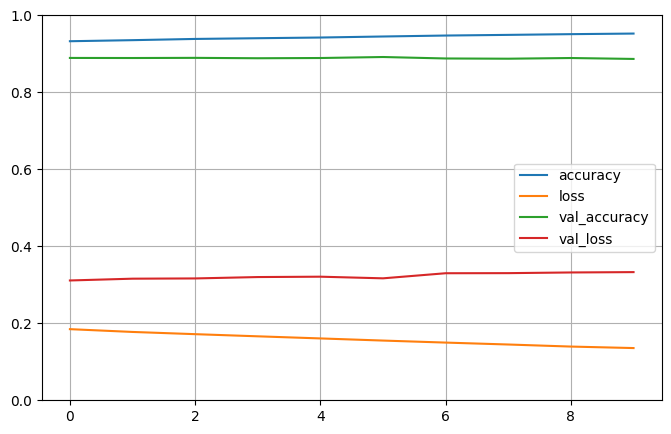

In [38]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
#save_fig("keras_learning_curves_plot")
plt.show()

Una vez que esté **satisfecho con la precisión de validación de su modelo**, debe evaluarla en el *conjunto de prueba* (test) para estimar el error de generalización antes de implementar el modelo en producción:

In [39]:
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8760 - loss: 0.3945


[0.39229637384414673, 0.8762999773025513]

- Como vimos anteriormente, es **común obtener un rendimiento ligeramente inferior en el conjunto de prueba** que en el conjunto de validación, porque los hiperparámetros están sintonizados en el conjunto de validación, no en el conjunto de prueba.

## Usando el modelo para hacer predicciones
A continuación, podemos usar el método *predict()* del modelo para hacer predicciones sobre nuevas instancias. Como no tenemos instancias nuevas reales, solo usaremos las primeras 3 instancias del **conjunto de prueba**:

**Nota**: recuerde que configuaramos la red para que a la salida nos arroje la probabilidad de membresia por clase, por eso nos arroja un vector en 0 y 1.

In [40]:
X_new = X_test[:10]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.08, 0.  , 0.01, 0.  , 0.  , 0.  , 0.91, 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.99, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 1.  , 0.  , 0.  ]],
      dtype=float32)

In [41]:
y_pred = model.predict(X_new).argmax(axis=1) #podemos utilizar argmax para estimar la salida ordinal
y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


array([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [42]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt', 'Trouser',
       'Coat', 'Shirt', 'Sandal', 'Sneaker'], dtype='<U11')

In [43]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

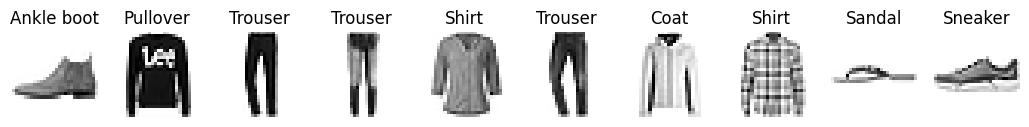

In [44]:
plt.figure(figsize=(13, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 10, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
#save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

## Regresión MLP

- Podemos utilizar un esquema de aprendizaje profundo, fijando la salida en activación lineal o ReLU para trabajar un problema de regresión.

- Carguemos, dividamos y escalemos el conjunto de datos de [vivienda de California](https://www.kaggle.com/camnugent/california-housing-prices):

In [45]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [46]:
np.random.seed(42)
tf.random.set_seed(42)

- Como tenemos una única salida tipo de regresión, la última capa tiene una única neurona con activación lineal (por defecto las capas dense vienen con activación lineal).

In [47]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1) #se fija una única con activacion lineal
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))
history  = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new    = X_test[:3]
y_pred   = model.predict(X_new)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.7677 - val_loss: 2.2346
Epoch 2/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8625 - val_loss: 0.7921
Epoch 3/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7652 - val_loss: 0.6541
Epoch 4/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7212 - val_loss: 0.6411
Epoch 5/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6860 - val_loss: 0.6290
Epoch 6/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6559 - val_loss: 0.6065
Epoch 7/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6295 - val_loss: 0.5882
Epoch 8/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6062 - val_loss: 0.5698
Epoch 9/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5855 - val_loss: 0.5527
Epoch 10/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5670 - val_loss: 0.5305
Epoch 11/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5506 - val_loss: 0.5123
Epoch 12/20
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.

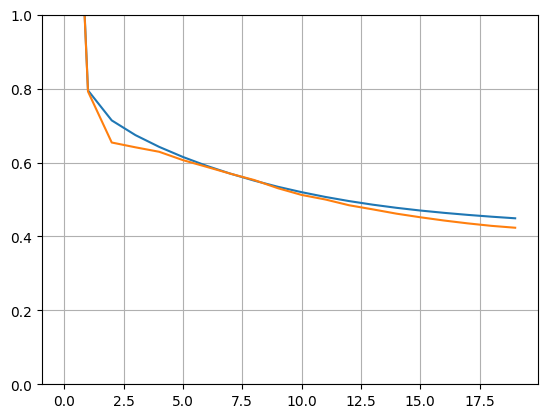

In [48]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [49]:
y_pred

array([[0.448181 ],
       [1.671582 ],
       [3.2696948]], dtype=float32)

Como puede ver, la API secuencial es **bastante fácil de usar**. Sin embargo, aunque los modelos secuenciales son extremadamente comunes, a veces es útil construir redes neuronales con topologías más complejas, o con múltiples entradas o salidas. Para este propósito, Keras ofrece la **API funcional**.

# Ejercicio:

- Configure el entorno de Colab para trabajar con GPU (Ver pestaña entorno de ejecución). Repita el entrenamiento del modelo de clasificación Fashion mnist para batch size en 32, 64, 128, 256, y 512. Reporte una tabla con los rendimientos sobre el conjunto de test y el tiempo promedio de cómputo por época.

- Repita el procedimiento del punto anterior configurando Colab para trabajar con TPU.